In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# TIME-SERIES
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from numpy import log

# Shots per 48

In [3]:
shots_per_48 = pd.read_csv('Data/Predictions/Shots/shots_2_3_per_48.csv', index_col=0)
print('NUMBER OF GAMES:', len(shots_per_48['GAME ID'].unique()))
shots_per_48

NUMBER OF GAMES: 26838


,GAME ID,SHOT TYPE,COUNT,SEASON ID,SEASON STAGE
0,20000001,2,117,2000-01,Regular Season
1,20000001,3,19,2000-01,Regular Season
2,20000002,2,146,2000-01,Regular Season
3,20000002,3,17,2000-01,Regular Season
4,20000003,2,128,2000-01,Regular Season
...,...,...,...,...,...
53671,42000404,3,52,2020-21,Playoffs
53672,42000405,2,127,2020-21,Playoffs
53673,42000405,3,47,2020-21,Playoffs
53674,42000406,2,116,2020-21,Playoffs


In [4]:
two_pointers = shots_per_48[shots_per_48['SHOT TYPE'] == 2]
three_pointers = shots_per_48[shots_per_48['SHOT TYPE'] == 3]

In [8]:
# FIND ORDER OF DIFFERENCING (d) IN ARIMA MODEL

'''
The purpose of differencing it to make the time series stationary.
But you need to be careful to not over-difference the series. Because, an over 
differenced series may still be stationary, which in turn will affect the model parameters.

So how to determine the right order of differencing?
The right order of differencing is the minimum differencing required to get a near-stationary
series which roams around a defined mean and the ACF plot reaches to zero fairly quick.
If the autocorrelations are positive for many number of lags (10 or more), then the series needs 
further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, 
then the series is probably over-differenced.

In the event you can't really decide between two orders of differencing, then go with the order 
that gives the least standard deviation in the differenced series.

You need differencing only if the series is non-stationary. Else, no differencing is needed, that 
is, d=0.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value 
of the test is less than the significance level (0.05) then you reject the null hypothesis and infer 
that the time series is indeed stationary.
'''

for df, df_name in zip([two_pointers, three_pointers], ['TWO', 'THREE']):
    print('{} POINTERS'.format(df_name))
    result = adfuller(df['COUNT'].dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

    if result[1] < 0.05:
        print('TIME SERIES IS STATIONARY (d=0)', end='\n'*2)
    else:
        print('DIFFERENCING NEEDED', end='\n'*2)

TWO POINTERS
ADF Statistic: -4.702212
p-value: 0.000083
TIME SERIES IS STATIONARY (d=0)

THREE POINTERS
ADF Statistic: -2.123128
p-value: 0.235317
DIFFERENCING NEEDED



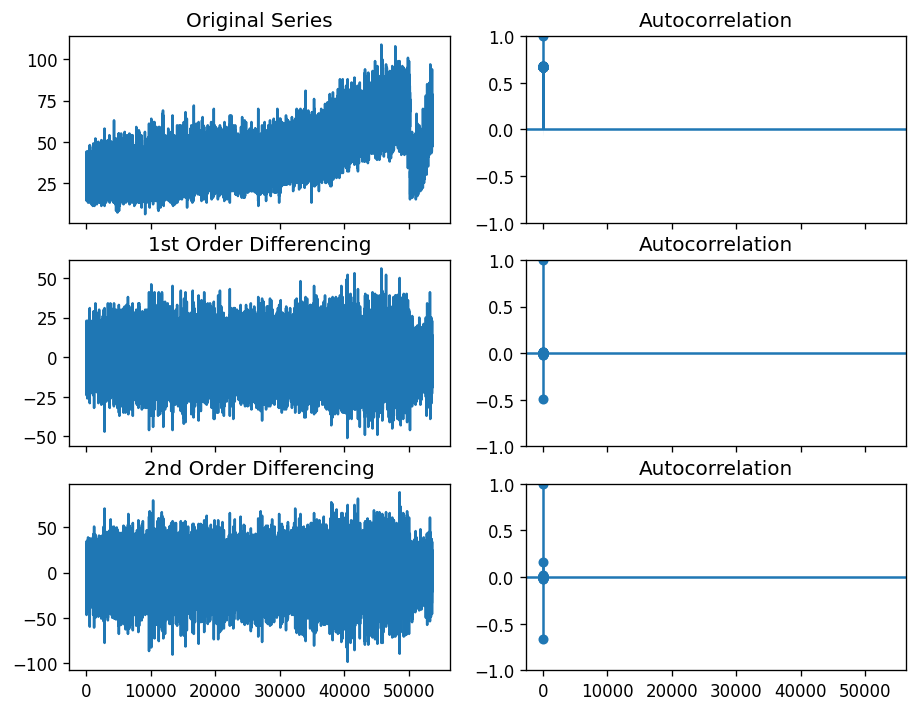

In [13]:
d_two_pointers = 0

# d_three_pointers = ?
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(three_pointers['COUNT']); axes[0, 0].set_title('Original Series')
plot_acf(three_pointers['COUNT'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(three_pointers['COUNT'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(three_pointers['COUNT'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(three_pointers['COUNT'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(three_pointers['COUNT'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

ValueError: not enough values to unpack (expected 3, got 2)

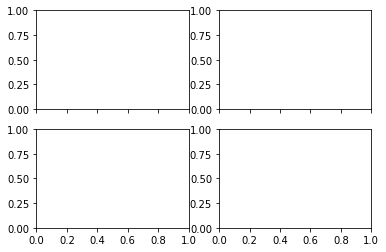

In [7]:
# FIND THE ORDER OF THE AR TERM (p)

'''
The next step is to identify if the model needs any AR terms. 
You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

But what is PACF?
Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding
the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag
and the series. That way, you will know if that lag is needed in the AR term or not.

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially 
take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.
'''

# PACF plot of 1st differenced series
# plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2, sharex=True)

for i, df, df_name in enumerate(zip([two_pointers, three_pointers], ['TWO', 'THREE'])):
    print('{} POINTERS'.format(df_name))

    axes[i].plot(df.diff()); axes[i].set_title('1st Differencing')
    axes[i+1].set(ylim=(0,5))
    plot_pacf(df.diff().dropna(), ax=axes[1])

plt.show()

In [15]:
avg_shots_per_48 = pd.read_csv('Data/Predictions/Shots/avg_shots_per_48.csv', index_col=0)
avg_shots_per_48.head()

,SEASON ID,SEASON STAGE,AVG SHOTS PER 48
0,2000-01,Playoffs,160.028169
1,2000-01,Regular Season,159.943650
2,2001-02,Playoffs,158.408451
3,2001-02,Regular Season,161.428932
4,2002-03,Playoffs,157.181818


In [37]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df = avg_shots_per_48[avg_shots_per_48['SEASON STAGE'] == 'Regular Season'].copy()
df.reset_index(inplace=True)

model = pm.auto_arima(
    df['AVG SHOTS PER 48'], 
    start_p=1, 
    start_q=1,
    test='adf',       # use adftest to find optimal 'd'
    max_p=21,         # maximum p and q
    max_q=21, 
    m=1,              # frequency of series
    d=None,           # let model determine 'd'
    seasonal=True,    # No Seasonality
    start_P=0, 
    D=0, 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=89.907, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=97.616, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=93.495, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=88.160, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=89.805, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.304 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 -42.080
Date:                Thu, 30 Jun 2022   AIC                             88.160
Time:                        19:07:09   BIC                             90.049
Sample:                             0   HQI

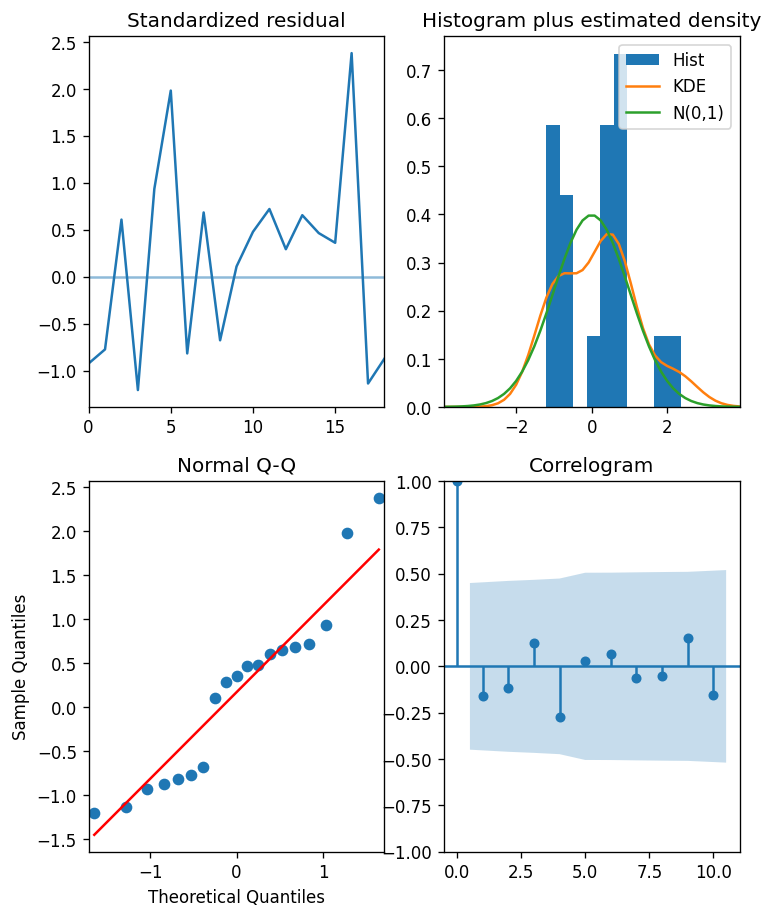

In [38]:
model.plot_diagnostics(figsize=(7,9))
plt.show()

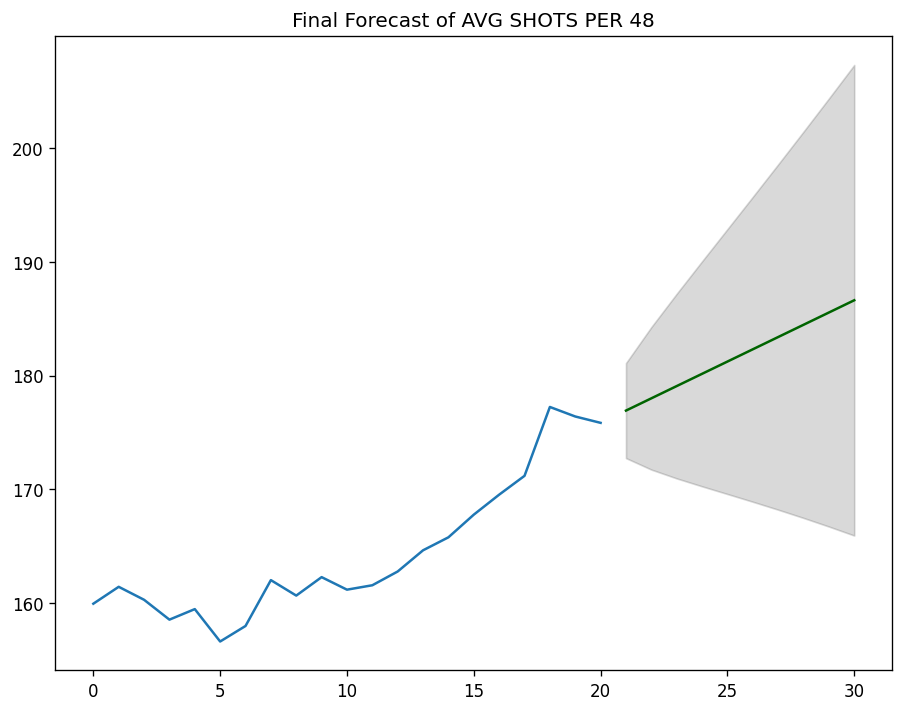

In [41]:
# Forecast
n_periods = 10
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df['AVG SHOTS PER 48']), len(df['AVG SHOTS PER 48'])+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df['AVG SHOTS PER 48'])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of AVG SHOTS PER 48")
plt.show()

In [62]:
df = shots_per_48[(shots_per_48['SEASON STAGE'] == 'Regular Season') & (shots_per_48['SHOT TYPE'] == 2)]
df.reset_index(inplace=True, drop=True)
df.head()

,GAME ID,SHOT TYPE,COUNT,SEASON ID,SEASON STAGE
0,20000001,2,117,2000-01,Regular Season
1,20000002,2,146,2000-01,Regular Season
2,20000003,2,128,2000-01,Regular Season
3,20000004,2,119,2000-01,Regular Season
4,20000005,2,157,2000-01,Regular Season


In [79]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

df = df[['COUNT']].copy()

model = pm.auto_arima(
    df, 
    start_p=1, 
    start_q=1,
    test='adf',       # use adftest to find optimal 'd'
    m=82,
    start_P=0, 
    D=None, 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic


KeyboardInterrupt: 

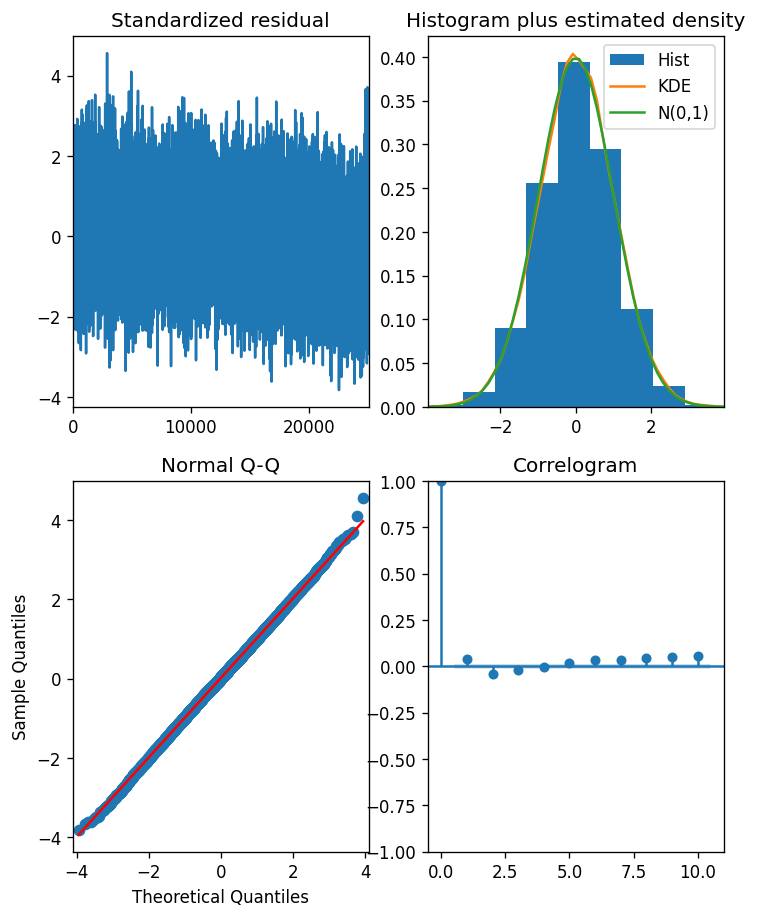

In [64]:
model.plot_diagnostics(figsize=(7,9))
plt.show()

In [77]:
fc_series

25104    118.996627
25105    118.328577
25106    118.856039
25107    119.198482
25108    119.521769
            ...    
25181    122.385217
25182    122.385340
25183    122.385450
25184    122.385549
25185    122.385638
Length: 82, dtype: float64

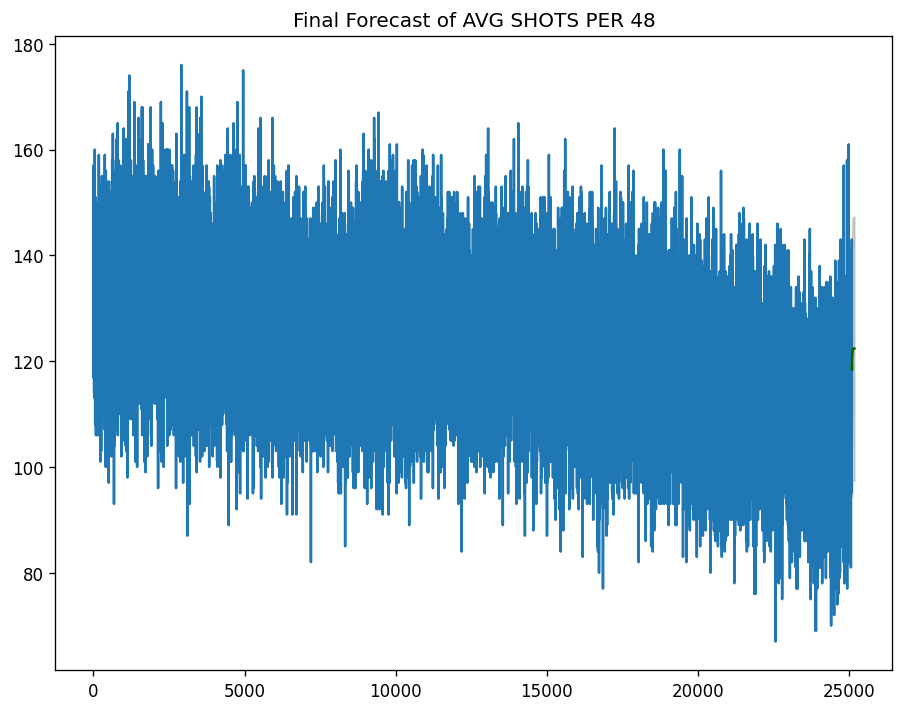

In [75]:
# Forecast
n_periods = 82
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df), len(df)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of AVG SHOTS PER 48")
plt.show()